This notebook follows an example from following website:

http://dfm.io/emcee/current/user/line/

for some reason the original plot codes are missing, so I figured it out by myself.

This is the preparation for a emcee module workshop on NWU computational reasearch day (April 10th, 2018).

In [1]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import corner

In [2]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

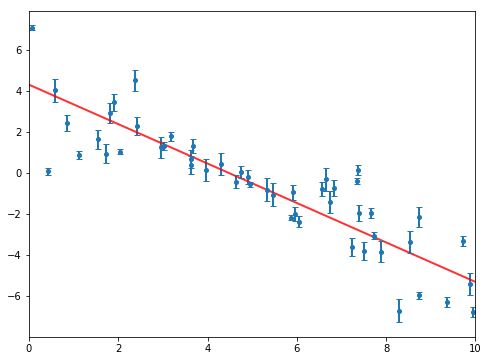

In [4]:
# plot the synthetic data
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.savefig('001.png')
plt.show()


In [5]:
# linear least squares solution to these data
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print(f"the results are: m={m_ls} and b={b_ls}")

the results are: m=-0.9244261534430598 and b=4.0765637839131195


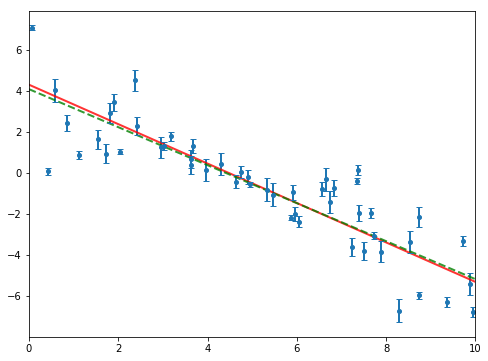

In [6]:
# plotted as a dashed green line
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.savefig('002.png')
plt.show()

In [7]:
# likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount: f. 
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [8]:
# finding this numerical optimum of this likelihood function using the scipy.optimize module
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print(f"the results are m={m_ml}, b={b_ml} and f={np.e**(lnf_ml)}")

the results are m=-0.8987126719866592, b=4.045663466534481 and f=0.5311472818358963


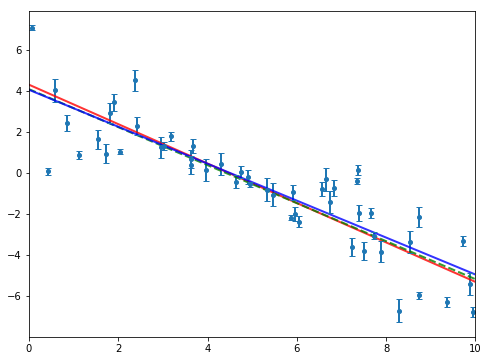

In [9]:
# plot all the data togther
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.plot(xl, m_ml*xl+b_ml, color="b", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.savefig('003.png')
plt.show()

In [ ]:
# the log-prior
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [ ]:
# the full log-probability function 
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [ ]:
# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
# set up the sampler using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [ ]:
# run the MCMC for 500 steps
sampler.run_mcmc(pos, 500)

In [ ]:
# plot positions of each walker as a function of the number of steps in the chain
x_axis = list(range(500))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10,10))

for i in range(100):
    m_walk = []
    b_walk = []
    f_walk = []
    for j in range(500):
        m_walk.append(sampler.chain[i][j][0])
        b_walk.append(sampler.chain[i][j][1])
        f_walk.append(np.e**(sampler.chain[i][j][2]))
    ax1.plot(x_axis, m_walk, color='k', linewidth=1)
    ax2.plot(x_axis, b_walk, color='k', linewidth=1)
    ax3.plot(x_axis, f_walk, color='k', linewidth=1)
plt.xlim(0,500)
plt.xlabel("Step Number")
ax1.set_ylabel("m")
ax1.axhline(y=-0.9594, color='r', linestyle='-')
ax2.set_ylabel("b")
ax2.axhline(y=4.294, color='r', linestyle='-')
ax3.set_ylabel("f")
ax3.axhline(y=0.534, color='r', linestyle='-')
plt.show()

In [ ]:
# discard the initial 50 steps and flatten the chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [ ]:
# based on MCMC results and generate a corner plot
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
plt.show()

In [ ]:
# choose a few (say 100 in this case) samples from the chain and plot them
fig = plt.figure(figsize=(8,6))
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=3)
plt.xlim(0,10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
# quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the 
# marginalized distributions
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [ ]:
# print and compare results with true values
print(f"Final results: m={m_mcmc[0]:.4f}, b={b_mcmc[0]:.4f} and f={f_mcmc[0]:.4f}")
print(f"True values: m={m_true}, b={b_true} and f={f_true}")